In [1]:
# import pandas as pd 
import matplotlib.pyplot as plt
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.dates as mdates
import cmocean as cmo
import matplotlib as mpl


sweep = pd.read_csv("parameter_space_ws_pmax.csv") 
# print(sweep)

PMA1X = sweep.pmax1.values
PMAX2 = sweep.pmax2.values
WS1 = sweep.ws1.values
WS2 = sweep.ws2.values

sub = sweep.loc[sweep['pmax1'] == max(PMA1X)]
sub = sub.loc[sweep['pmax2'] == max(PMAX2)]
# sub = sub.loc[sweep['ws2'] == sweep['ws2'].iloc[0]]
fn = sub['fout_name'].values 

# print(fn)
files2read_strat = ["output/strat_%d.nc" % i for i in fn]
files2read_unstrat = ["output/unstrat_%d.nc" % i for i in fn]

pmax1 = sub.pmax1.values[0]
pmax2 = sub.pmax2.values[0]
ws1 = sub.ws1.values
ws2 = sub.ws2.values

# print(pmax1, pmax2)
# print(ws1, ws2)
print(files2read_strat)
print(ws1)

FileNotFoundError: [Errno 2] No such file or directory: 'parameter_space_ws_pmax.csv'

In [ ]:
# get dates
dates = pd.read_csv("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/CIMIS/PAR_on_august_9-15.csv")
dates = dates.time 
dates = pd.to_datetime(dates)
dates = dates[::1000].reset_index(drop=True)
# dates = dates[0:-1]
print(dates.iloc[36:43])

36   2024-08-13 04:00:00
37   2024-08-13 06:46:40
38   2024-08-13 09:33:20
39   2024-08-13 12:20:00
40   2024-08-13 15:06:40
41   2024-08-13 17:53:20
42   2024-08-13 20:40:00
Name: time, dtype: datetime64[ns]


: 

KeyboardInterrupt: 

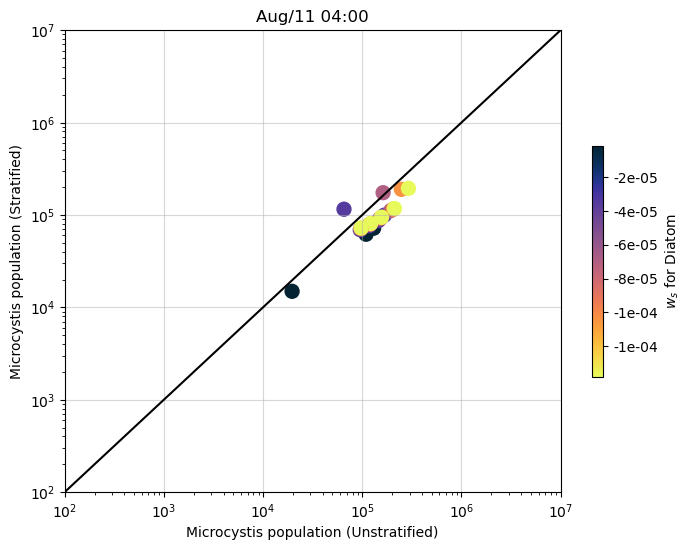

In [3]:

# from celluloid import Camera

# dz = 0.12 # m 
# dz3 = 12**3 

kwargs = { "linewidth":4, "alpha":0.7} 

def ws12color(ws):
    frac = abs(ws/max(abs(ws1)))
    return cmo.cm.thermal(frac)

def get_biomass(data): 
    biomass1 = data.sum(dim="z")
    return biomass1

def reshape(my_list):
    arr1 = np.array(my_list).reshape(5,5)
    arr1 = arr1 #/ np.max(arr1.ravel())
    return arr1





u_hab = np.zeros((len(files2read_strat), 52))
s_hab = np.zeros((len(files2read_strat), 52))
u_diatom = np.zeros((len(files2read_strat), 52))
s_diatom = np.zeros((len(files2read_strat), 52))

for ind,i in enumerate(files2read_strat):

    # Open stratified data
    data = xr.open_dataset(files2read_strat[ind])
    
    s_diatom[ind,:] = get_biomass(data.algae1)
    s_hab[ind,:] = get_biomass(data.algae2)

    # Open unstratified data
    data = xr.open_dataset(files2read_unstrat[ind]) 
    u_diatom[ind,:] = get_biomass(data.algae1)
    u_hab[ind,:] = get_biomass(data.algae2)


import matplotlib.animation as animation

plt.close()
fig1 = plt.figure(figsize=(8,6))
ax1 = plt.gca()
ax1.plot([0, 1e7], [0, 1e7], '-k')
norm = mpl.colors.Normalize(vmax=max(ws1), vmin=min(ws1))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmo.cm.thermal_r, ), 
            label="$w_s$ for Diatom", shrink=0.5, pad=0.05, ax=ax1,format='%.0e')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e3, 1e10)
ax1.set_ylim(1e3, 1e10)
ax1.set_xlabel("Diatom Biomass (Unstratified)")
ax1.set_ylabel("Diatom Biomass (Stratified)")
ax1.grid(alpha=0.5)
scat = ax1.scatter(np.zeros(len(ws1)), np.zeros(len(ws1)), c=ws1, cmap=cmo.cm.thermal, vmax=max(ws1), vmin=min(ws1), s=100)
# scat.set_offsets([])

def format(ax):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.5)
    ax.plot([0, 1e10], [0, 1e10], '-k')
    return ax

def update_hab(INDEX, ax1): 
    ax1.cla() 
    scat = ax1.scatter(u_hab[:,INDEX], s_hab[:,INDEX], c=np.flip(ws1), cmap=cmo.cm.thermal, vmax=max(ws1), vmin=min(ws1), s=100)
    ax1 = format(ax1)

    ax1.set_xlim(1e2, 1e7)
    ax1.set_ylim(1e2, 1e7)
    ax1.set_xlabel("Microcystis population (Unstratified)")
    ax1.set_ylabel("Microcystis population (Stratified)")
    ax1.set_title(dates.iloc[INDEX].strftime("%b/%d %H:00"))
    fig1.canvas.draw()
    fig1.savefig("plots/hab_%d.png" % INDEX)
    return 

def update_diatom(INDEX, ax1): 
    ax1.cla() 
    scat = ax1.scatter(u_diatom[:,INDEX], s_diatom[:,INDEX], c=np.flip(ws1), cmap=cmo.cm.thermal, vmax=max(ws1), vmin=min(ws1), s=100)
    ax1 = format(ax1)

    ax1.set_xlim(1e0, 1e6)
    ax1.set_ylim(1e0, 1e6)
    ax1.set_xlabel("Diatom Population (Unstratified)")
    ax1.set_ylabel("Diatom Population (Stratified)")
    ax1.set_title(dates.iloc[INDEX].strftime("%b/%d %H:00"))
    fig1.canvas.draw()
    fig1.savefig("plots/diatom_%d.png" % INDEX)

    return 

# plt.show()

for i in range(0, 52):
    update_hab(i, ax1)


In [19]:


import imageio
images = []

for k in range(0,52):
    images.append(imageio.imread("plots/hab_%d.png" % k))
imageio.mimsave('hab_diatom.gif', images, fps=5) #duration=1)

/tmp/ipykernel_2205553/3221732844.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("plots/hab_%d.png" % k))


In [2]:
# get dates
light = pd.read_csv("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/CIMIS/PAR_on_august_10-16.csv")
light.index = pd.to_datetime(light.time)


wind = pd.read_csv("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/forcing_data/wind_on_august_10-16.csv")
wind.index = pd.to_datetime(wind.time)
wind['average'] = wind['WindSpeed'].rolling(window=400).mean()

strat = pd.read_csv("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/Stratification parameters time series_data.csv")
strat.index = pd.to_datetime(strat['Timestamp'])
strat = strat.loc[strat['Site'] == 'WEB']
strat = strat[~strat.index.duplicated(keep='first')]
# PE_Anomaly (J/m^3)


dates = wind.index.values
dates = dates[::6] #.reset_index(drop=True)
dss = xr.open_dataset("output/STRAT_HAB_HIGH_RES_0.nc")
dsu = xr.open_dataset("output/UNSTRAT_HAB_HIGH_RES_0.nc")
print(dsu)

/tmp/ipykernel_2095128/438443490.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  strat.index = pd.to_datetime(strat['Timestamp'])


<xarray.Dataset> Size: 46MB
Dimensions:  (z: 60, time: 8640)
Coordinates:
  * z        (z) float32 240B 5.95 5.85 5.75 5.65 5.55 ... 0.35 0.25 0.15 0.05
  * time     (time) timedelta64[ns] 69kB 00:00:01 00:00:02 ... 02:23:59 02:24:00
Data variables:
    U        (time, z) float64 4MB ...
    Kq       (time, z) float64 4MB ...
    Nu       (time, z) float64 4MB ...
    C        (time, z) float64 4MB ...
    Kz       (time, z) float64 4MB ...
    L        (time, z) float64 4MB ...
    Q2       (time, z) float64 4MB ...
    Q2L      (time, z) float64 4MB ...
    N_BV2    (time, z) float64 4MB ...
    algae1   (time, z) float64 4MB ...
    algae2   (time, z) float64 4MB ...
Attributes:
    title:    ws1 = -6.969e-5, ws2 = 0.00103845, pmax1 = 1.0001279295763457, ...


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f779a82b9d0>
Traceback (most recent call last):
  File "/global/homes/s/siennaw/.conda/envs/schimpy/lib/python3.9/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

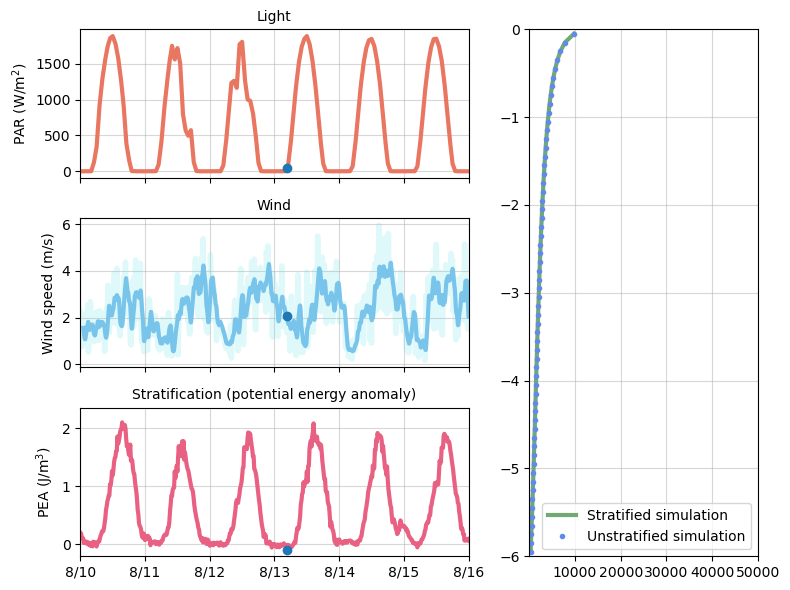

In [23]:
for index in range(100, 8600, 10):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,6), sharex=True, gridspec_kw={'width_ratios': [1.7, 1]})

    gs = axs[0, 1].get_gridspec()
    # remove the underlying Axes
    for ax in axs[0:, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[0:, 1])


    axs = axs.flatten()
    axs[0].plot(light.index, light['Sol Rad (PAR)'], linewidth=3, color="#E87661")
    axs[0].set_ylabel("PAR (W/m$^2$)")
    axs[0].set_title("Light", fontsize=10)
    axs[0].set_xlim(light.index[0], light.index[-1])

    axs[2].plot(wind.index, wind['WindSpeed'], color="#61E3E8", linewidth=4, alpha=0.2)
    axs[2].plot(wind.index, wind['average'], linewidth=3, color="#79C4EB")
    axs[2].set_ylabel("Wind speed (m/s)")
    axs[2].set_title("Wind", fontsize=10)

    axs[4].plot(strat.index, strat['PE_Anomaly (J/m^3)'], linewidth=3, color="#E86183")
    axs[4].set_ylabel("PEA (J/m$^3$)")
    axs[4].set_title("Stratification (potential energy anomaly)", fontsize=10)


    for ax in axs:
        ax.grid(alpha=0.5)


    myFmt = mdates.DateFormatter('8/%d') # %H:00')
    axs[4].xaxis.set_major_locator(mdates.HourLocator(interval=24))
    axs[4].xaxis.set_major_formatter(myFmt)


    axbig.plot(dss.algae2.isel(time=index), -dss.z, label="Stratified simulation", color="#71A874", linewidth=3)
    axbig.plot(dsu.algae2.isel(time=index), -dsu.z,'.', label="Unstratified simulation", color="#618AE8", linewidth=3)
    axbig.set_ylim(-6,0)
    axbig.grid(alpha=0.5)
    axbig.set_xlim(1e0, 5e4)
    # axbig.set_xscale("log")


    site = "WP" 
    TIME = dates[index]
    # print(TIME)

    axs[0].plot(TIME, light['Sol Rad (PAR)'].loc[TIME], 'o')
    axs[2].plot(TIME, wind['average'].loc[TIME], 'o')
    index_ = strat.index.get_indexer([TIME], method='nearest')#, method='nearest')
    axs[4].plot(TIME, strat['PE_Anomaly (J/m^3)'].iloc[index_], 'o')

    axbig.legend(loc='lower right')

    plt.tight_layout()
    # assert(False)
    # print(dsu.algae1.isel(time=index).values)
    fig.savefig("gif3/hab_%d.png" % index)
    plt.close()

(100000.0, 300000.0)

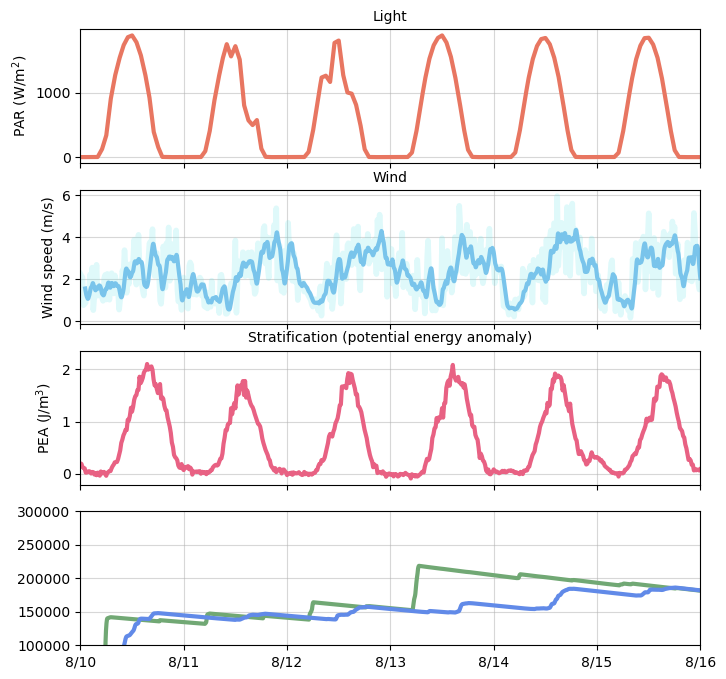

In [ ]:
biomass_s = dss.algae2.sum(dim='z')
biomass_u = dsu.algae2.sum(dim='z')

fig, axs = plt.subplots(nrows = 4, ncols= 1, figsize=(8,8), sharex=True)

axs = axs.flatten()
axs[0].plot(light.index, light['Sol Rad (PAR)'], linewidth=3, color="#E87661")
axs[0].set_ylabel("PAR (W/m$^2$)")
axs[0].set_title("Light", fontsize=10)
axs[0].set_xlim(light.index[0], light.index[-1])

axs[1].plot(wind.index, wind['WindSpeed'], color="#61E3E8", linewidth=4, alpha=0.2)
axs[1].plot(wind.index, wind['average'], linewidth=3, color="#79C4EB")
axs[1].set_ylabel("Wind speed (m/s)")
axs[1].set_title("Wind", fontsize=10)

axs[2].plot(strat.index, strat['PE_Anomaly (J/m^3)'], linewidth=3, color="#E86183")
axs[2].set_ylabel("PEA (J/m$^3$)")
axs[2].set_title("Stratification (potential energy anomaly)", fontsize=10)


axs[3].plot(dates[0:-1], biomass_s/biomass_u, label="Stratified simulation", color="#71A874", linewidth=3)
# axs[3].plot(dates[0:-1], biomass_u, label="Unstratified simulation", color="#618AE8", linewidth=3)

for ax in axs:
    ax.grid(alpha=0.5)


myFmt = mdates.DateFormatter('8/%d') # %H:00')
axs[3].xaxis.set_major_locator(mdates.HourLocator(interval=24))
axs[3].xaxis.set_major_formatter(myFmt)
# axs[3].set_ylim(1e5, 3e5)



In [ ]:

import imageio
images = []

for k in range(100, 5700, 10):
    images.append(imageio.imread("gif2/diatom_%d.png" % k))
imageio.mimsave('COMPARING_SIMS.gif', images, fps=8) #duration=1)

/tmp/ipykernel_2205553/4042053940.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("gif2/diatom_%d.png" % k))


In [11]:
for index in range(0, 5000, 10):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,6), sharex=True, gridspec_kw={'width_ratios': [1.7, 1]})

    gs = axs[0, 1].get_gridspec()
    # remove the underlying Axes
    for ax in axs[0:, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[0:, 1])


    axs = axs.flatten()
    axs[0].plot(light.index, light['Sol Rad (PAR)'], linewidth=3, color="#E87661")
    axs[0].set_ylabel("PAR (W/m$^2$)")
    axs[0].set_title("Light", fontsize=10)
    axs[0].set_xlim(light.index[0], light.index[-1])

    axs[2].plot(wind.index, wind['WindSpeed'], color="#61E3E8", linewidth=4, alpha=0.2)
    axs[2].plot(wind.index, wind['average'], linewidth=3, color="#79C4EB")
    axs[2].set_ylabel("Wind speed (m/s)")
    axs[2].set_title("Wind", fontsize=10)

    axs[4].plot(strat.index, strat['PE_Anomaly (J/m^3)'], linewidth=3, color="#E86183")
    axs[4].set_ylabel("PEA (J/m$^3$)")
    axs[4].set_title("Stratification (potential energy anomaly)", fontsize=10)


    for ax in axs:
        ax.grid(alpha=0.5)


    myFmt = mdates.DateFormatter('8/%d') # %H:00')
    axs[4].xaxis.set_major_locator(mdates.HourLocator(interval=24))
    axs[4].xaxis.set_major_formatter(myFmt)

    axbig.plot(dss.U.isel(time=index), -dss.z, label="Stratified simulation", color="#71A874", linewidth=3)
    axbig.plot(dsu.U.isel(time=index), -dsu.z,'.', label="Unstratified simulation", color="#618AE8", linewidth=3)
    axbig.set_ylim(-6,0)
    axbig.grid(alpha=0.5)
    axbig.set_xlim(-0.75, 0.75)

    site = "WP" 
    TIME = dates[index]
    # print(TIME)

    axs[0].plot(TIME, light['Sol Rad (PAR)'].loc[TIME], 'o')
    axs[2].plot(TIME, wind['average'].loc[TIME], 'o')
    index_ = strat.index.get_indexer([TIME], method='nearest')#, method='nearest')
    axs[4].plot(TIME, strat['PE_Anomaly (J/m^3)'].iloc[index_], 'o')

    axbig.legend(loc='lower right')
    axbig.set_ylabel("Depth (m)")
    axbig.set_xlabel("Velocity (m/s)")

    plt.tight_layout()
    fig.savefig("gif3/U_%d.png" % index)
    plt.close()

In [ ]:
import imageio
images = []

for k in range(100, 5700, 10):
    images.append(imageio.imread("gif3/U_%d.png" % k))
imageio.mimsave('U.gif', images, fps=8) #duration=1)

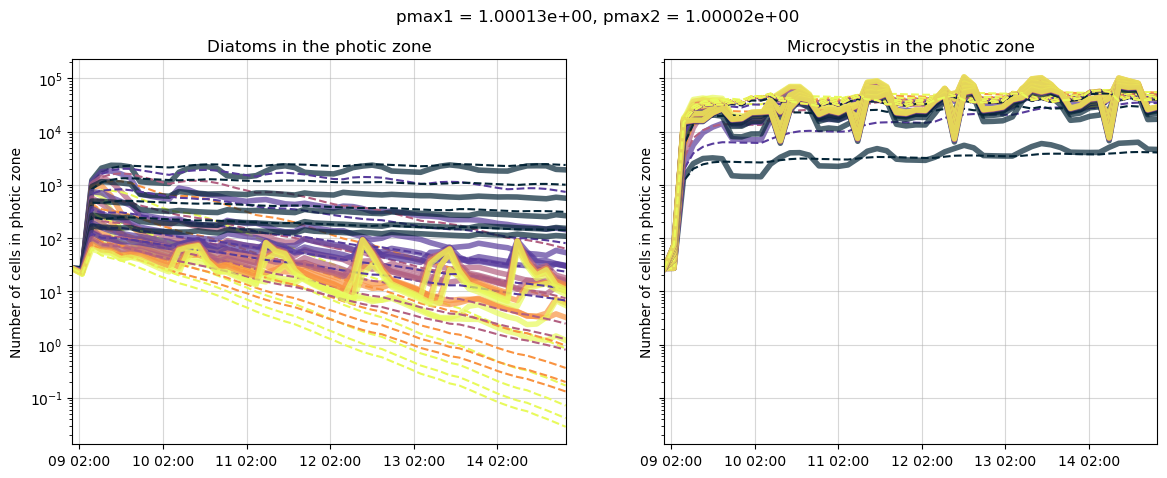

In [ ]:
import cmocean as cmo

dz = 0.12 # m 
dz3 = 1 #dz**3 

kwargs = { "linewidth":4, "alpha":0.7} 
def ws12color(ws):
    frac = abs(ws/max(abs(ws1)))
    return cmo.cm.thermal(frac)


fig, axs = plt.subplots(nrows=1,ncols=2,  sharex=True, sharey=True, figsize=(14,5))

for ind,i in enumerate(files2read_strat):
    
    data = xr.open_dataset(files2read_strat[ind], decode_times=False)

    photic_biomass1 = data.algae1[:,-10:-1].values * dz3
    photic_biomass1 = np.sum(photic_biomass1, axis=1) 

    photic_biomass2 = data.algae2[:,-10:-1].values * dz3
    photic_biomass2 = np.sum(photic_biomass2, axis=1)

    if ind %1 == 0:
        axs[0].plot(dates, photic_biomass1, label="[Stratified] ws1=%2.1e, ws2=%2.1e" % (ws1[ind],ws2[ind]), color =  ws12color(ws1[ind]), **kwargs)
        axs[1].plot(dates, photic_biomass2, label="[Stratified] ws1=%2.1e, ws2=%2.1e" % (ws1[ind],ws2[ind]), color =  ws12color(ws1[ind]), **kwargs)

    else:
        axs[0].plot(dates, photic_biomass1, color =  ws12color(ws1[ind]), **kwargs)
        axs[1].plot(dates, photic_biomass2, color =  ws12color(ws1[ind]), **kwargs)

    data = xr.open_dataset(files2read_unstrat[ind])
    photic_biomass1 = data.algae1[:,-10:-1].values * dz3
    photic_biomass1 = np.sum(photic_biomass1, axis=1) 

    photic_biomass2 = data.algae2[:,-10:-1].values * dz3
    photic_biomass2 = np.sum(photic_biomass2, axis=1)
    if ind % 2 == 0:
        axs[0].plot(dates, photic_biomass1, '--',  color =  ws12color(ws1[ind]))
        axs[1].plot(dates, photic_biomass2, '--',  color =  ws12color(ws1[ind]))

    else:
        axs[0].plot(dates, photic_biomass1, '--', color =  ws12color(ws1[ind]))
        axs[1].plot(dates, photic_biomass2, '--', color =  ws12color(ws1[ind]))

    photic_biomass = data.algae2[:,-10:-1].values * dz3
    photic_biomass = np.sum(photic_biomass, axis=1)


for ax in axs:
    ax.set_yscale('log')
    ax.grid(alpha=0.5)
    ax.set_ylabel("Number of cells in photic zone")
    # ax.legend(loc="lower left")
    ax.set_xlim(dates.iloc[0],dates.iloc[-1])

axs[0].set_title("Diatoms in the photic zone")
axs[1].set_title("Microcystis in the photic zone")


myFmt = mdates.DateFormatter('%d %H:00')
# Set locator
axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=24))
axs[0].xaxis.set_major_formatter(myFmt)

title = "pmax1 = %2.5e, pmax2 = %2.5e" % (pmax1,pmax2)
plt.suptitle(title)
fig.savefig(title + ".png")
    # algae1 = sum(data.algae1[-1,:].values - data.algae1[0,:].values)
    # algae2 = sum(data.algae2[-1,:].values - data.algae2[0,:].values)
    # print("Algae1 = %f, Algae2 = %f" % (algae1,algae2))



(19944.0, 19948.97685185185)

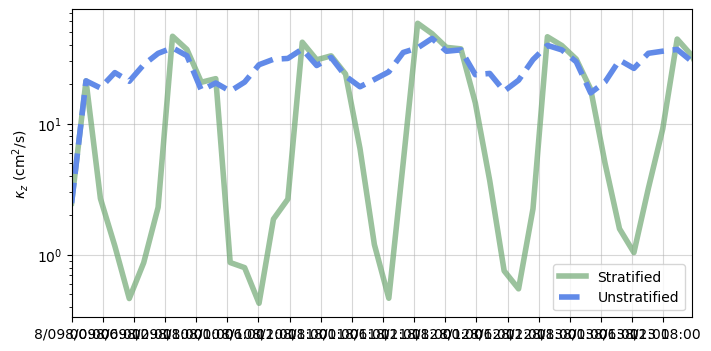

In [ ]:
import cmocean as cmo

fig = plt.figure(figsize=(8,4))
ax = plt.gca() 


dz = 0.12 # m 
dz3 = 12**3 

kwargs = { "linewidth":4, "alpha":0.7} 
def ws12color(ws):
    frac = abs(ws/max(abs(ws1)))
    return cmo.cm.thermal(frac)

ind = 0 
data = xr.open_dataset(files2read_strat[ind], decode_times=False)

Kz = data.Kz.values
Kz = np.mean(Kz, axis=1) 

ax.plot(dates, Kz*(100*100),  color="#71A874", **kwargs, label="Stratified")

data = xr.open_dataset(files2read_unstrat[ind], decode_times=False)

Kz2 = data.Kz.values
Kz2 = np.mean(Kz2, axis=1) 



    # axbig.plot(dss.algae1.isel(time=index), -dss.z, label="Stratified simulation", color="#71A874", linewidth=3)
    # axbig.plot(dsu.algae1.isel(time=index), -dsu.z,'.', label="Unstratified simulation", color="#618AE8", linewidth=3)


ax.plot(dates, Kz2*(100*100), '--', color="#618AE8", linewidth=4, label="Unstratified")

# print(dates)
# ax.set_xlim(dates.iloc[0], dates.iloc[-1])
# ax.set_yscale('log')
ax.grid(alpha=0.5)
ax.set_ylabel(r"$\kappa_z$ (cm$^2$/s)")
ax.legend()
ax.set_yscale("log")
myFmt = mdates.DateFormatter('8/%d %H:00')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim(dates.iloc[10],dates.iloc[43])




In [ ]:
# import xarray as xr 
# import cmocean as cmo
# import matplotlib.pyplot as plt

# NN= 10
# def i2color(i):
#     frac = abs(i/20)
#     return cmo.cm.thermal(frac)


# ds = xr.open_dataset("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/stratified_0.nc")

# fig, axs = plt.subplots(nrows=1,ncols=NN,  sharex=True, sharey=True, figsize=(10,5))

# var = "L"
# data1 = ds[var].dropna(dim="time")
# # data1 = xr.open_dataset(files2read_strat[0], decode_times=False)
# # data2 = xr.open_dataset(files2read_unstrat[ind], decode_times=False)

# print(data1.time.values)
# vec = range(0, 10, 1)
# for i, ind in enumerate(vec):
#     var1 = data1.sel(time=(i*5000)) #values[:, ind]
#     axs[i].plot(var1, data1.z, color = i2color(i),label="Stratified")

# for ax in axs:
#     ax.grid(alpha=0.25)
#     ax.set_xlim(0,1)
#     # ax.set_ylabel(r"$\kappa_z$ (m$^2$/s)")

# plt.suptitle("Stratified PYTHON RESULT")

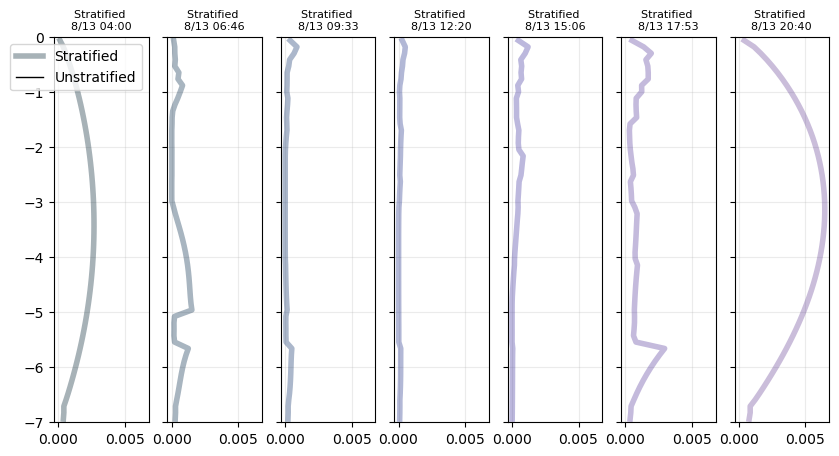

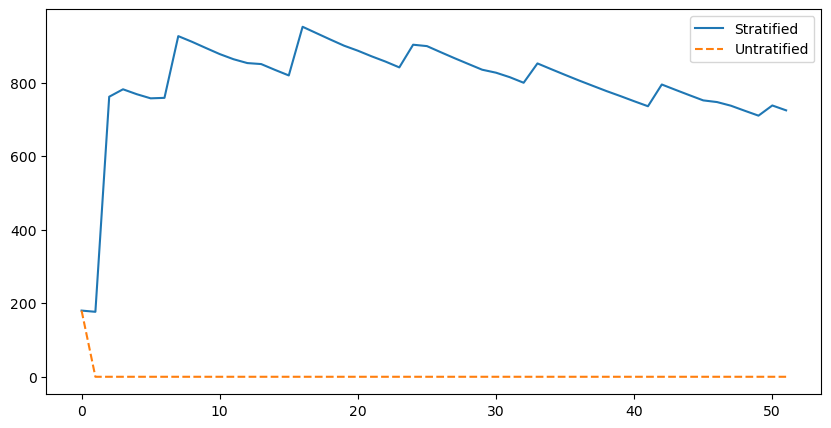

In [ ]:
import cmocean as cmo
kwargs = { "linewidth":4, "alpha":0.35} 

def i2color(i):
    frac = abs(i/20)
    return cmo.cm.thermal(frac)

ind = 0 

NN = 7 
fig, axs = plt.subplots(nrows=1, ncols=NN,  sharex=True, sharey=True, figsize=(10,5))

fig2 = plt.figure(figsize=(10,5))
ax2 = plt.gca()


data1 = xr.open_dataset(files2read_strat[20], decode_times=False)
data2 = xr.open_dataset(files2read_unstrat[20], decode_times=False)

biomass_strat = data1.algae1.sum(dim="z")  #* 1e-3
biomass_unstrat = data2.algae1.sum(dim="z")# * 1e-3

ax2.plot(biomass_strat, label="Stratified")
ax2.plot(biomass_unstrat,'--', label="Untratified")
ax2.legend()
# ax2.set_xlim(36,43)
# print(data1.C.sel(time=1).values)


VAR = "Kz"
vec = range(36, 43, 1)
# 36:43
start_time = pd.to_datetime("August 9, 2024 00:00:00")


for i, ind in enumerate(vec):
    # print("Ind = %d" % ind)
    if i >= NN:
        break

    time = start_time + pd.Timedelta(seconds=ind*1000*10)
    algae1 = data1[VAR].values[ind,:]
    # print(algae1)
    axs[i].plot(algae1, -data1.z, color = i2color(i), **kwargs, label="Stratified")
    axs[i].set_title("Stratified \n" + time.strftime("8/%d %H:%M"), fontsize=8)

    algae1 = data2[VAR].values[ind,:]
    # print(algae1)
    axs[i].plot( algae1, -data2.z, '-', linewidth=1, color ='k', label="Unstratified")
    # axs[1,i].set_title("Unstratified" , fontsize=7)


# ax.grid(alpha=0.5)
# ax.set_ylabel(r"$\kappa_z$ (m$^2$/s)")

for ax in axs.ravel():
    ax.grid(alpha=0.25)
    ax.set_ylim(-7,0)
axs[0].legend()
    # ax.set_xlim(0,0.5)
    # turn axis off 
    # ax.set_axis_off()
# ax.legend()

# fig.savefig("TKE.png")

In [ ]:
# import xarray as xr 
# import matplotlib.pyplot as plt
# ds = xr.open_dataset("/global/homes/s/siennaw/scratch/siennaw/1D_JL_Turbulence_Model/output/unstrat_0.nc")
# # print(ds)
# ds2 = xr.open_dataset("/global/homes/s/siennaw/scratch/siennaw/turbulence-model/stratified_0.nc")
# # print(ds2)
# # print(ds.data_vars)
# # print(ds2.data_vars)
# var = "Kz"
# dsu = ds2[var].dropna(dim="time")
# print(dsu)
# print(dsu.time.values)
# # print(ds.time.values)
# for i in range(0,5):
#     var1 = ds[var].isel(time=i).values
#     var2 = dsu.sel(time=(i*10))
#     plt.plot(var1, -ds.z.values, label="%d" % i)
#     plt.plot(var2, ds2.z.values, '--k', label="python")

# print(dsu.shape)

# fig = plt.figure()



import cmocean as cmo 
import matplotlib as mpl

data2plot1 = np.zeros((len(ws1),1))
data2plot2 = np.zeros((len(ws1),1))

for ind,i in enumerate(files2read_strat):
    data = xr.open_dataset(i)
    algae1 = sum(data.algae1[-1,:].values - data.algae1[0,:].values)
    algae2 = sum(data.algae2[-1,:].values - data.algae2[0,:].values)
    # print("Algae1 = %f, Algae2 = %f" % (algae1,algae2))
    data2plot1[ind] = algae1 
    data2plot2[ind] = algae2


NORM0 = mpl.colors.LogNorm()

fig = plt.figure() 
# plt.xscale('log')
# plt.yscale('log')
h = plt.pcolor(ws1.reshape(5,5), ws2.reshape(5,5), data2plot1.reshape(5,5), cmap=cmo.cm.thermal, norm=NORM0)
ax = plt.gca() 
plt.colorbar(h)
ax.set_xlabel("pmax1")
ax.set_ylabel("pmax2")


fig = plt.figure() 
# Set colorscale to log 
# plt.xscale('log')
# plt.yscale('log')
h = plt.pcolor(ws1.reshape(5,5), ws2.reshape(5,5), data2plot2.reshape(5,5), cmap=cmo.cm.thermal, norm=NORM0)
ax = plt.gca() 
plt.colorbar(h)
ax.set_xlabel("pmax1")
ax.set_ylabel("pmax2")


